# Simple power spectrum estimation from an input dataset
This example shows how to estimate the power spectrum from a set of data files using an Optimal Quadratic Estimator (OQE) approach.

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy

## Loading the input data
The input data are specified as a list of `UVData` objects, which are then packaged into a `PSpecData` class. This class is responsible for collecting the data and covariances together and performing the OQE power spectrum estimation. At least two `UVData` objects must be specified -- power spectra are only ever estimated on independent datafiles, to remove noise bias.

In [2]:
# List of filenames of the data to load
dfile = '../hera_pspec/data/zen.2458042.12552.xx.HH.uvXAA',
beamfile = '../hera_pspec/data/NF_HERA_Beams.beamfits'
uvb = hp.pspecbeam.PSpecBeamUV(beamfile)

# Load into UVData objects
uvd = UVData()
uvd.read_miriad(dfile)

# Check which baseline pairs are available
print(uvd.get_antpairs())

[(24, 24), (24, 25), (24, 38), (25, 25), (25, 38), (38, 38)]


In [3]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1:], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

## Estimating the power spectrum for a handful of baseline pairs
Estimate the power spectrum for a handful baseline pairs between the two datasets in `ds.dsets`. You can specify which baselines are included in the power spectrum estimate, which datasets to use, what freq channels to use, and how the estimate should be weighted.

The result is a `UVPSpec` object that holds all of the power spectra and their meta-data.

In [4]:
# Specify which baselines to include
bls = [(24,25), (24,38), (25,38)]

# Calculate the power spectrum using: 
# bls list for bls1 and bls list for bls2
# datasets 0 for bls1 and 1 for bls2
# spectral range of channels 20 - 30
# identity weighting
uvp = ds.pspec(bls, bls, (0, 1), spw_ranges=[(20,30), (40,50)], input_data_weight='identity', norm='I', 
               taper='blackman-harris', verbose=True)


Setting spectral range: (20, 30)

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 38), (24, 38))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((25, 38), (25, 38))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (40, 50)

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 38), (24, 38))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectru

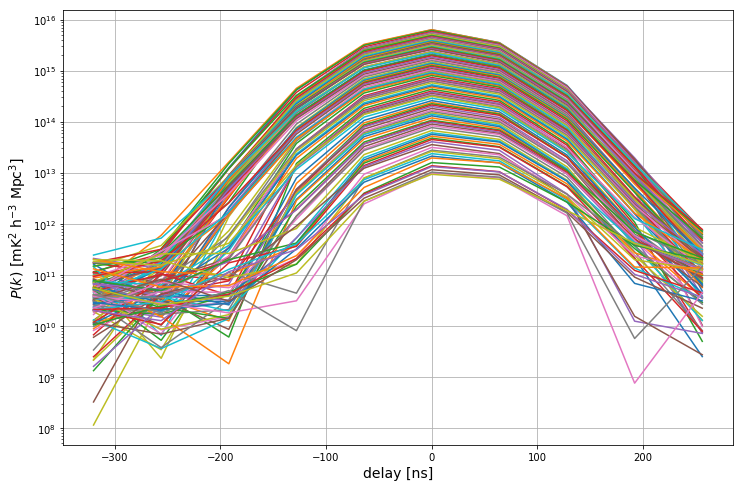

In [5]:
# plot power spectrum of spw 0
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
dlys = uvp.dly_array[uvp.spw_to_indices(spw)] * 1e9
power = np.abs(np.real(uvp.get_data(spw, ((24, 25), (24,25)), 'xx')))

_ = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)

## Calculate using redundant baseline grouping

You can also feed `pspec` a list of redundant baseline groups and it will compute all cross spectra in each group. Note that these baselines actually aren't redundant (just b/c they are the only baselines in the file). Because of that, `pspec` will raise an warning that their baseline-vectors are non-redundant within a 1 meter tolerance.

In [7]:
bls = [[(24,25), (24,38), (25,38)]]

# Calculate the power spectrum using: 
# bls list for bls1 and bls list for bls2
# datasets 0 for bls1 and 1 for bls2
# spectral range of channels 20 - 30
# identity weighting
uvp = ds.pspec(bls, bls, (0, 1), spw_ranges=[(20,30), (40,50)], input_data_weight='identity', norm='I', 
               taper='blackman-harris', verbose=True)

baseline-pair residual(s) in the 0'th bl group exceed a bl tol of 1.0 m

Setting spectral range: (20, 30)

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 25), (24, 38))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 25), (25, 38))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 38), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 38), (24, 38))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Buildin

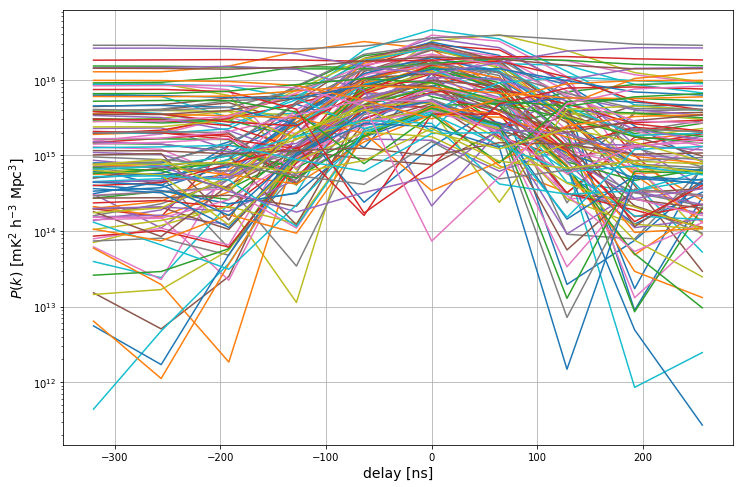

In [11]:
# plot power spectrum of spw 0
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
dlys = uvp.dly_array[uvp.spw_to_indices(spw)] * 1e9
power = np.abs(np.real(uvp.get_data(spw, ((24, 25), (25,38)), 'xx')))

_ = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)